In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

# Plotgröße festlegen
mpl.rcParams['figure.figsize'] = (10, 7)

### Daten definieren

In [2]:
# Anzahl gehörter Info-/Biovorlesungen
informatik = np.array([0, 0, 2, 3, 4, 4, 4, 5, 6, 7])
bio = np.array([0, 1, 1, 2, 2, 4, 5, 5, 6, 6])
X = np.c_[informatik, bio]

# 0: kein Interesse | 1: Interesse
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

X_0 = X[y == 0] # alle Datenpunkte mit y = 0
X_1 = X[y == 1] # alle Datenpunkte mit y = 1

### Daten aufteilen

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

### Daten visualisieren

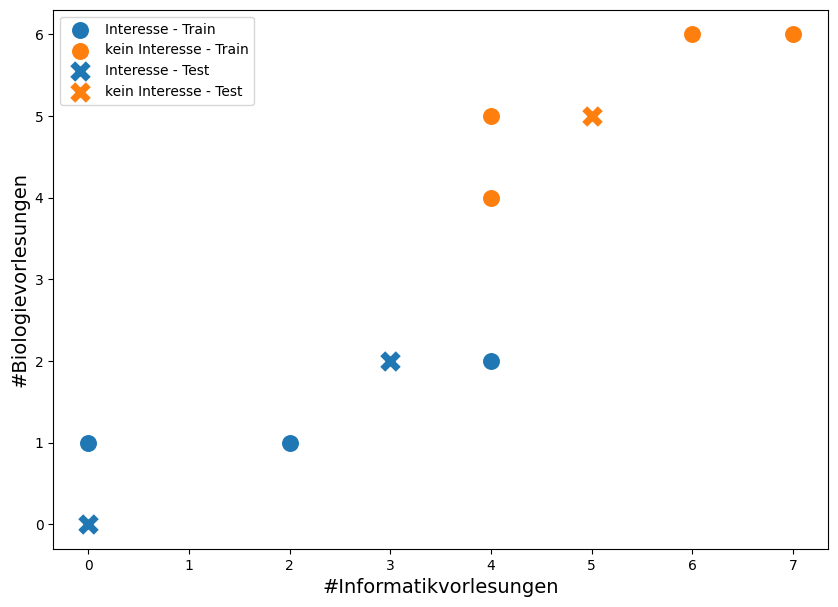

In [5]:
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1]

plt.scatter(X_train_0[:,0], X_train_0[:,1], label="Interesse - Train", color='#1f77b4', s=125)
plt.scatter(X_train_1[:,0], X_train_1[:,1], label="kein Interesse - Train", color='#ff7f0e', s=125)

plt.scatter(X_test_0[:,0], X_test_0[:,1], marker="x", label="Interesse - Test", color='#1f77b4', s=125, linewidth=5)
plt.scatter(X_test_1[:,0], X_test_1[:,1], marker="x", label="kein Interesse - Test", color='#ff7f0e', s=125, linewidth=5)

plt.xlabel("#Informatikvorlesungen", fontsize=14)
plt.ylabel("#Biologievorlesungen", fontsize=14)
plt.legend()
plt.show()

### Vorhersage

In [6]:
class BayesClassifier():

    # Hilfsfunktion
    # Bestimme die bedinte Wahrscheinlichkeit P(x|y)
    # hierbei ist curr_label = y, feature_value = x
    def compute_categorical_likelihood(self, curr_label, feature_idx, feature_value):
        Y_curr_idx = self.Y == curr_label # data points with y = curr_label
        X_curr = self.X[Y_curr_idx]
        likelihood = (1+len(X_curr[X_curr[:,feature_idx] == feature_value])) / len(X_curr) # p(x | y)
        return likelihood

    # Trainingsfunktion
    # Berechne prior probabilities (priors) und speichere ein paar Hilfsvariablen ab
    def fit(self, X, Y):
        self.classes = np.unique(Y)
        self.num_data_points = len(Y)
        #self.priors = [ len(Y[Y==curr_y])/len(Y) for curr_y in self.classes ]
        self.priors = [ np.log(len(Y[Y==curr_y])/len(Y)) for curr_y in self.classes ]
        self.Y = Y
        self.X = X

    # Vorhersagefunktion
    # Wende Satz von Bayes für jedes Label an und wähle die Vorhersage mit maximaler Wahrscheinlichkeit
    def predict(self, X):
        Y_pred = []
        for x in X:
            # berechne alle Klassenwahrscheinlichkeiten
            likelihoods = []
            for curr_label in self.classes:
                curr_likelihood = 1
                for idx,feature in enumerate(x):
                    curr_likelihood *= self.compute_categorical_likelihood(curr_label, idx, feature)
                likelihoods.append(curr_likelihood)

            # berechne posterior probabilities (posteriors, nur Zähler)
            posteriors = [likelihoods[idx] + self.priors[idx] for idx in range(len(self.classes))]
            y_pred = self.classes[np.argmax(posteriors)]
            Y_pred.append(y_pred)

        return np.array(Y_pred)

### Vergleich unserer Implementierung vs. sklearn

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [9]:
our_multinomial_bayes = BayesClassifier()
our_multinomial_bayes.fit(X_train, y_train)

sklearn_multinomial_bayes = MultinomialNB()
sklearn_multinomial_bayes.fit(X_train, y_train)

our_multinomial_acc = accuracy_score(y_test, our_multinomial_bayes.predict(X_test))
sklearn_multinomial_acc = accuracy_score(y_test, sklearn_multinomial_bayes.predict(X_test))

print(f"Unsere Accuracy: {our_multinomial_acc:.3f} | Sklearn-Accuracy: {sklearn_multinomial_acc:.3f}")

Unsere Accuracy: 0.333 | Sklearn-Accuracy: 0.333


### Decision Boundary visualisieren

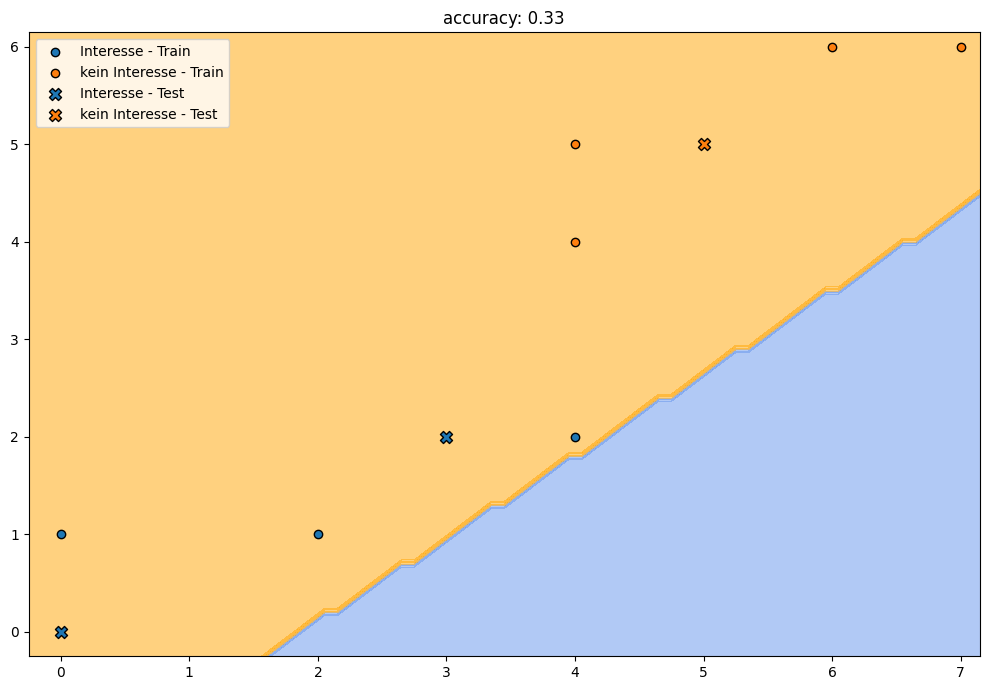

In [10]:
res = 0.1  # Auflösung des Grids

# Intervallgrenzen
x_max, y_max = np.max(X, axis=0) + 0.25 
x_min, y_min = np.min(X, axis=0) - 0.25

# Colormap definieren
cmap_light = ListedColormap([ 'cornflowerblue', 'orange'])

# Grid definieren
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, res),
                             np.arange(y_min, y_max, res))
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

# Vorhersagen und score berechnen
sklearn_score = sklearn_multinomial_bayes.score(X_test, y_test)
sklearn_grid_out = sklearn_multinomial_bayes.predict(grid_input).reshape(grid_x.shape)

# Plot erstellen
plt.title(f'accuracy: {np.round(sklearn_score,2)}')
plt.contourf(grid_x, grid_y, sklearn_grid_out, alpha=0.5, cmap=cmap_light) #plt.cm.cividis)

plt.scatter(X_train_0[:,0], X_train_0[:,1], label="Interesse - Train", edgecolor='k')
plt.scatter(X_train_1[:,0], X_train_1[:,1], label="kein Interesse - Train", edgecolor='k')

plt.scatter(X_test_0[:,0], X_test_0[:,1], s=75, label="Interesse - Test", marker="X", edgecolor='k', color='#1f77b4')
plt.scatter(X_test_1[:,0], X_test_1[:,1], s=75, label="kein Interesse - Test", marker="X", edgecolor='k', color='#ff7f0e')

plt.tight_layout()
plt.legend()
plt.show()
plt.close()